In [337]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import os
import folium

In [338]:
def file_path(filename):
    return os.path.join("../../data/clean", filename)

output_dir = "../visualizations"
os.makedirs(output_dir, exist_ok=True)

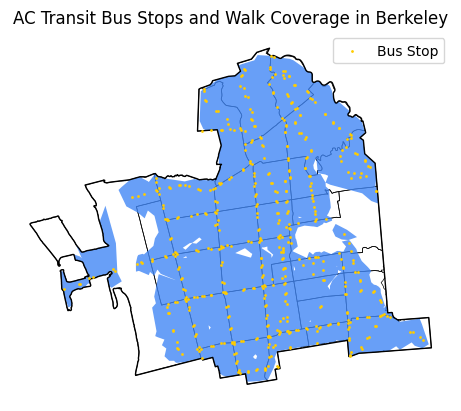

In [339]:
berkeley_boundary = gpd.read_file(
    file_path("berkeley_boundary.geojson")
)
berkeley_tracts = gpd.read_file(
    file_path("berkeley_tracts.geojson")
)
berkeley_tracts = gpd.clip(berkeley_tracts, berkeley_boundary)
berkeley_stops = gpd.read_file(
    file_path("berkeley_stops.geojson")
)
coverage = gpd.read_file(
    file_path("coverage.geojson")
)

fig, ax = plt.subplots()

berkeley_tracts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
coverage.plot(ax=ax, color="#4287f5", alpha=0.8)
berkeley_boundary.plot(ax=ax, color="none", edgecolor="black")
berkeley_stops.plot(ax=ax, markersize=1, color="#ffcc00", label="Bus Stop")

ax.set_title("AC Transit Bus Stops and Walk Coverage in Berkeley")
ax.set_axis_off()

plt.legend()
plt.savefig("../visualizations/coverage.png")
plt.show()

In [340]:
time_order = [
    "Overnight (1–4:59)",
    "Early AM (5–6:59)",
    "AM Peak (7–9:59)",
    "Midday (10–14:59)",
    "PM Peak (15–18:59)",
    "Evening (19–21:59)",
    "Late Night (22–0:59)",
]

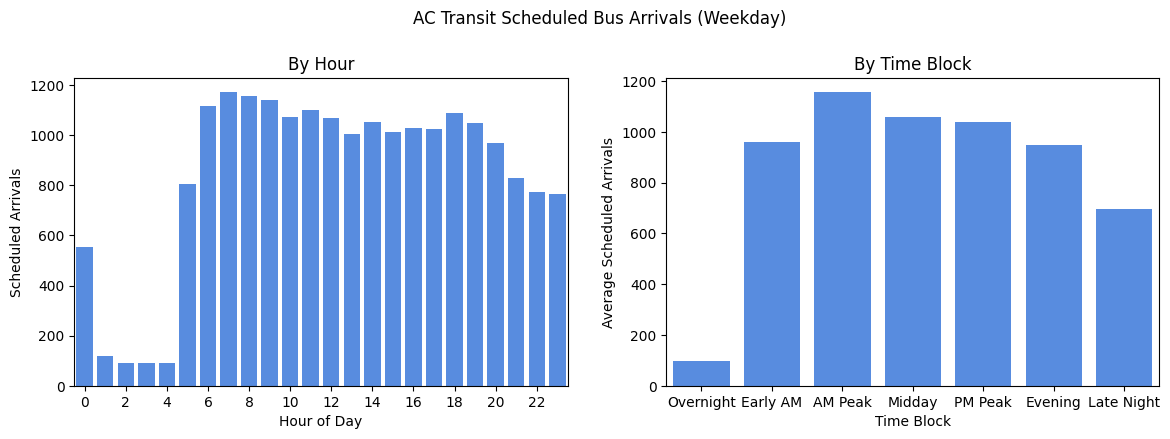

In [341]:
hourly_arrivals = pd.read_csv(
    file_path("hourly_arrivals.csv")
)
time_block_arrivals = pd.read_csv(
    file_path("time_block_arrivals.csv")
)

fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
fig.suptitle("AC Transit Scheduled Bus Arrivals (Weekday)", y=1.05)

sns.barplot(
    data=hourly_arrivals,
    x="hour",
    y="arrivals",
    color="#4287f5",
    ax=axes[0]
)

axes[0].set_xticks(range(0, 24, 2))
axes[0].set_title("By Hour")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Scheduled Arrivals")

sns.barplot(
    data=time_block_arrivals,
    x="time_block",
    y="average_arrivals",
    color="#4287f5",
    order=time_order,
    ax=axes[1]
)

time_block_labels = [
    "Overnight",
    "Early AM",
    "AM Peak",
    "Midday",
    "PM Peak",
    "Evening",
    "Late Night",
]

axes[1].set_xticks(range(len(time_block_labels)))
axes[1].set_xticklabels(time_block_labels)

axes[1].set_title("By Time Block")
axes[1].set_xlabel("Time Block")
axes[1].set_ylabel("Average Scheduled Arrivals")

plt.savefig("../visualizations/arrivals.png")
plt.show()

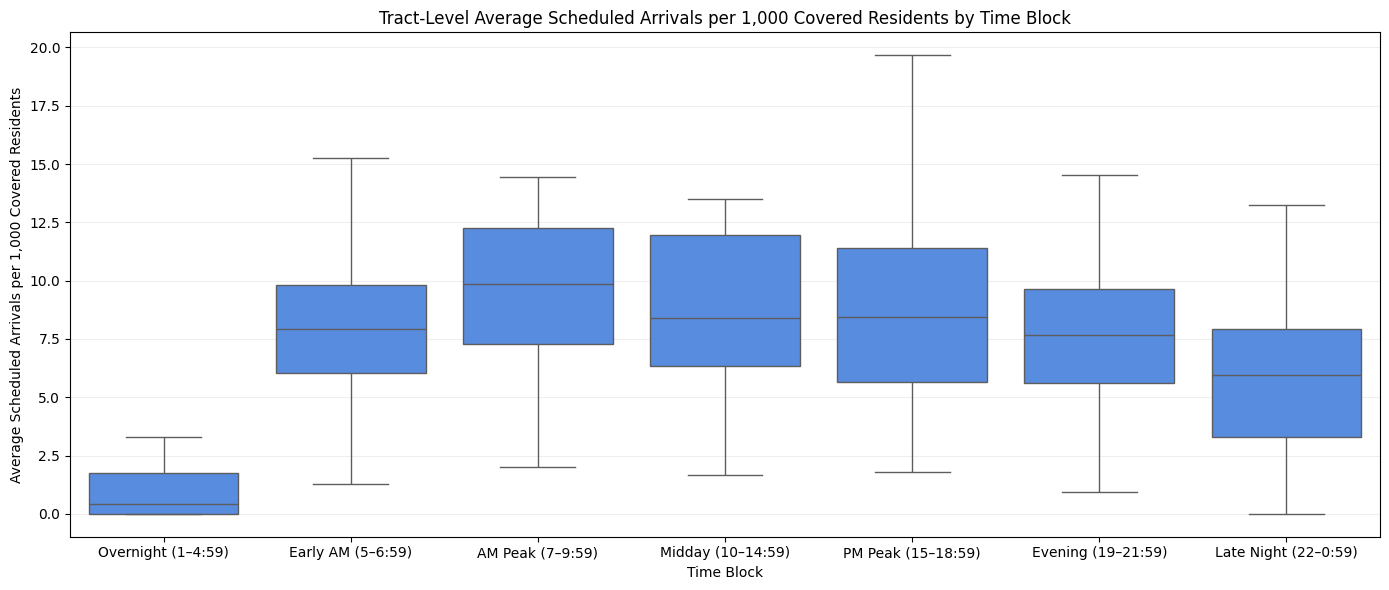

In [342]:
tract_time_block_arrivals = gpd.read_file(
    file_path("tract_time_block_arrivals.geojson")
)

plt.figure(figsize=(14, 6))

ax = sns.boxplot(
    data=tract_time_block_arrivals,
    x="time_block",
    y="average_arrivals_per_1000_covered",
    order=time_order,
    showfliers=False,
    color="#4287f5",
)

ax.set_xlabel("Time Block")
ax.set_ylabel("Average Scheduled Arrivals per 1,000 Covered Residents")
ax.set_title("Tract-Level Average Scheduled Arrivals per 1,000 Covered Residents by Time Block")

ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.savefig("../visualizations/tract_arrivals.png")
plt.show()

In [343]:
def web_crs(gdf):
    return gdf.to_crs(epsg=4326)

berkeley_coords = web_crs(berkeley_boundary).geometry.representative_point().iloc[0]
berkeley_coords = (berkeley_coords.y, berkeley_coords.x)

coverage = gpd.read_file(
    file_path("coverage.geojson")
)

m = folium.Map(
    location=berkeley_coords,
    zoom_start=13,
    tiles="cartodb positron"
)

web_crs(coverage).explore(
    m=m,
    name="6-min Walk Coverage (500m)",
    highlight=False,
    tooltip=False,
    style_kwds={
        "fillOpacity": 0.4,
        "weight": 1,
    }
)

web_crs(berkeley_stops).explore(
    m=m,
    name="Bus Stops",
    highlight=False,
    tooltip=False,
    color="#222222"
)

web_crs(berkeley_boundary).explore(
    m=m,
    name="Berkeley Land Boundary",
    highlight=False,
    tooltip=False,
    color="#2B2B2B",
    style_kwds={
        "fillOpacity": 0,
        "weight": 2,
    }
)

folium.LayerControl(collapsed=False).add_to(m)
m.save("../visualizations/berkeley_6min_walk_access_bus_stops.html")

m

In [344]:
peak_time_block_arrivals = gpd.read_file(
    file_path("peak_time_block_arrivals.geojson")
)

Text(0.5, 1.0, 'AM Peak Bus Service by Zero-Vehicle Household Share')

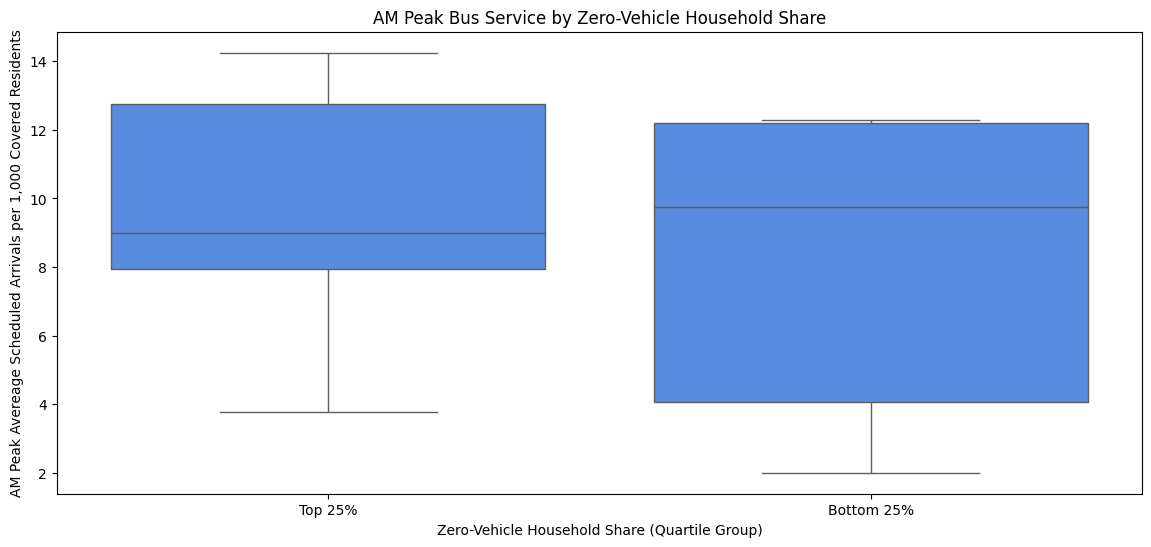

In [345]:
am_time_block_arrivals = peak_time_block_arrivals[peak_time_block_arrivals["time_block"] == "AM Peak (7–9:59)"].reset_index(drop=True)
q25 = am_time_block_arrivals["%_no_vehicle_households"].quantile(0.25)
q75 = am_time_block_arrivals["%_no_vehicle_households"].quantile(0.75)

am_time_block_arrivals["access_group"] = "Middle 50%"

am_time_block_arrivals.loc[am_time_block_arrivals["%_no_vehicle_households"] <= q25, "access_group"] = "Top 25%"
am_time_block_arrivals.loc[am_time_block_arrivals["%_no_vehicle_households"] >= q75, "access_group"] = "Bottom 25%"

am_time_block_arrivals = am_time_block_arrivals[(am_time_block_arrivals["access_group"] == "Bottom 25%") | (am_time_block_arrivals["access_group"] == "Top 25%")]

plt.figure(figsize=(14, 6))

ax = sns.boxplot(
    data=am_time_block_arrivals,
    x="access_group",
    y="average_arrivals_normalized",
    showfliers=False,
    color="#4287f5",
)

ax.set_xlabel("Zero-Vehicle Household Share (Quartile Group)")
ax.set_ylabel("AM Peak Avereage Scheduled Arrivals per 1,000 Covered Residents")
ax.set_title("AM Peak Bus Service by Zero-Vehicle Household Share")

Text(0.5, 1.0, 'PM Peak Bus Service by Zero-Vehicle Household Share')

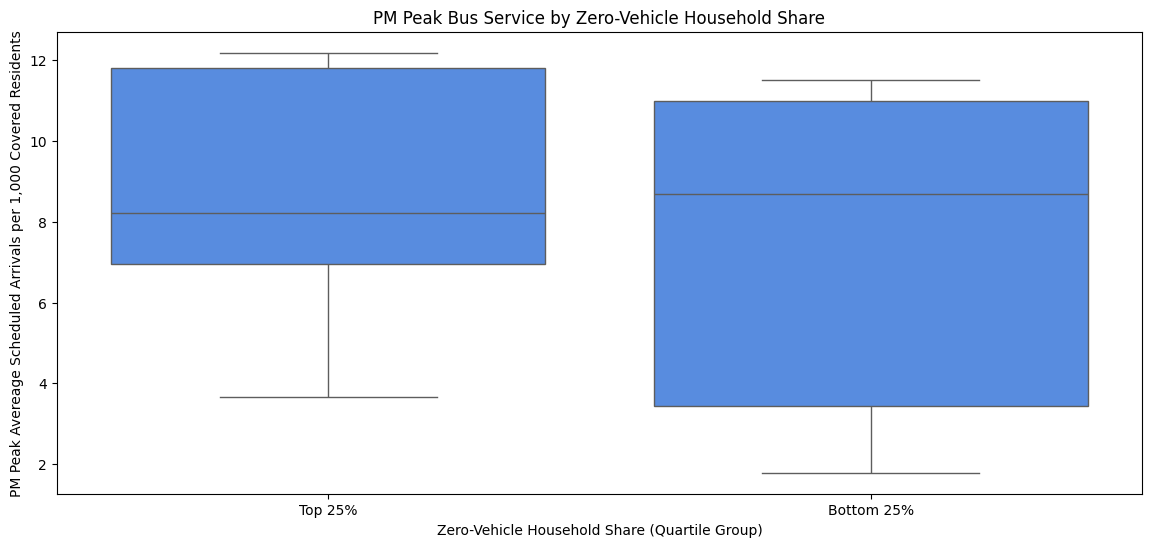

In [346]:
pm_time_block_arrivals = peak_time_block_arrivals[peak_time_block_arrivals["time_block"] == "PM Peak (15–18:59)"].reset_index(drop=True)
q25 = pm_time_block_arrivals["%_no_vehicle_households"].quantile(0.25)
q75 = pm_time_block_arrivals["%_no_vehicle_households"].quantile(0.75)

pm_time_block_arrivals["access_group"] = "Middle 50%"

pm_time_block_arrivals.loc[pm_time_block_arrivals["%_no_vehicle_households"] <= q25, "access_group"] = "Top 25%"
pm_time_block_arrivals.loc[pm_time_block_arrivals["%_no_vehicle_households"] >= q75, "access_group"] = "Bottom 25%"

pm_time_block_arrivals = pm_time_block_arrivals[(pm_time_block_arrivals["access_group"] == "Bottom 25%") | (pm_time_block_arrivals["access_group"] == "Top 25%")]

plt.figure(figsize=(14, 6))

ax = sns.boxplot(
    data=pm_time_block_arrivals,
    x="access_group",
    y="average_arrivals_normalized",
    showfliers=False,
    color="#4287f5",
)

ax.set_xlabel("Zero-Vehicle Household Share (Quartile Group)")
ax.set_ylabel("PM Peak Avereage Scheduled Arrivals per 1,000 Covered Residents")
ax.set_title("PM Peak Bus Service by Zero-Vehicle Household Share")